In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy.misc import comb
from sklearn.model_selection import train_test_split , KFold, StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.preprocessing import normalize
import pdb
from sklearn.metrics import roc_auc_score , make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import NuestroArbol as ourTree
import random
from scipy.stats import randint as sp_randint
from time import time
import collections
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from IPython.core.display import HTML

%matplotlib inline

# Importo datos 

In [2]:
X_comp = pd.read_csv('X_competencia.csv')
X = pd.read_csv('X.csv')
y = pd.read_csv('y.csv')
X.drop(['index'],inplace=True, axis=1)
y.drop(['index'], inplace=True,axis=1)



In [3]:
#partimos los datos en desarrollo(87%) y holdout(13%). 
X_desarrollo , X_holout ,y_desarrollo, y_holdout = train_test_split(X, y['output'],
                                                                    test_size=0.13,random_state=0,stratify=y['output'])

#a = normalize(X_desarrollo, axis=0, copy=True, return_norm=False)
#from IPython.core.debugger import Tracer; Tracer()() 
#X_desarrollo = pd.DataFrame(SelectKBest(chi2, k=180).fit_transform(np.abs(X_desarrollo), y_desarrollo))

#pase los kfold aca arriba ya que se usan en varios lugares.
#evaluar si esta bueno que siempre se usen los mismos folds
kfold = StratifiedKFold(n_splits=5)
kfold.get_n_splits(X_desarrollo,y_desarrollo)


5

### K-fold CV 

In [4]:
def primerTablaEjercicio2(treeClasifier):
    
    accuracy_train=[]
    accuracy_valildation=[]
    ROC_AUC_train=[]
    ROC_AUC_validation=[]

    #este for itera sobre los k folds en cada loop tego un set de datos y otro de validacion
    for train, test  in kfold.split(X_desarrollo,y_desarrollo):
        #print("TRAIN:", train_index,'\n', "TEST:", test_index,'\n' )
        X_train, X_val = X_desarrollo.iloc[train], X_desarrollo.iloc[test]
        y_train, y_val = y_desarrollo.iloc[train], y_desarrollo.iloc[test]
        #intancio el arbol que voy a entrenar en cada fold
        tree = treeClasifier(max_depth=3, criterion="gini")
        
        #from IPython.core.debugger import Tracer; Tracer()()

        tree.fit(X_train, y_train.astype(int))
        accuracy_train.append(tree.score(X=X_train, y=y_train))
        accuracy_valildation.append(tree.score(X=X_val, y=y_val))
        ROC_AUC_train.append(roc_auc_score(y_train,tree.predict(X_train)))
        ROC_AUC_validation.append(roc_auc_score(y_val,tree.predict(X_val)))
        
    return pd.DataFrame({ 'Partición' : np.arange(1,6),'Accuracy (training)' :accuracy_train,
                          'Accuracy (validación)' : accuracy_valildation,
                          'ROC AUC (training)' : ROC_AUC_train,
                          'ROC AUC (validación)' : ROC_AUC_validation})






# Tabla de precision

In [5]:
display(primerTablaEjercicio2(DecisionTreeClassifier))  

,Partición,Accuracy (training),Accuracy (validación),ROC AUC (training),ROC AUC (validación)
0,1,0.783862,0.659091,0.785980,0.660417
1,2,0.813218,0.758621,0.801587,0.752394
2,3,0.830460,0.597701,0.820954,0.588564
3,4,0.844828,0.597701,0.841170,0.592287
4,5,0.828080,0.639535,0.823049,0.628751


# Arboles combinaciones

In [6]:
def accuracyForTrainingAndValidation(depth,criteria,treeClasifier):
    acc_train=[]
    acc_val=[]


    #este for itera sobre los k folds en cada loop tego un set de training y otro de validacion
    for train, test  in kfold.split(X_desarrollo,y_desarrollo):
        #print("TRAIN:", train_index,'\n', "TEST:", test_index,'\n' )
        X_train, X_val = X_desarrollo.iloc[train], X_desarrollo.iloc[test]
        y_train, y_val = y_desarrollo.iloc[train], y_desarrollo.iloc[test]
        #intancio el arbol que voy a entrenar en cada fold
        tree = treeClasifier(max_depth=depth, criterion=criteria)

        tree.fit(X_train, y_train.astype(int))
        acc_train.append(tree.score(X=X_train, y=y_train))
        acc_val.append(tree.score(X=X_val, y=y_val))
        
    return {"training":np.mean(acc_train), "validation": np.mean(acc_val)}

        

In [7]:
def segundaTablaEjercicio2(treeClasifier):

    trainingResults=[]
    validationResults=[]
    evaluatedDepths=[]
    evaluatedCriterias=[]
    depthsDictionary={3:'3',5:'5',None:'Infinito'}
    depths = [3,5,None]    
    criterias =['gini','entropy']

    for depth in depths:
        for criteria in criterias:
            trainingResults.append(accuracyForTrainingAndValidation(depth,criteria,treeClasifier)["training"])
            validationResults.append(accuracyForTrainingAndValidation(depth,criteria,treeClasifier)["validation"])
            evaluatedDepths.append(depthsDictionary[depth])
            evaluatedCriterias.append(criteria)
    
    return pd.DataFrame({ 'Altura Máxima' : evaluatedDepths,
                          'Criterio de evaluación de corte' : evaluatedCriterias,
                          'Accuracy (training)' : trainingResults,
                          'Accuracy (validación)' : validationResults}).sort_values(by=['Criterio de evaluación de corte'],ascending=False)

# Tabla con combinaciones

In [8]:
display(segundaTablaEjercicio2(DecisionTreeClassifier))  

,Altura Máxima,Criterio de evaluación de corte,Accuracy (training),Accuracy (validación)
0,3,gini,0.820090,0.655127
2,5,gini,0.930453,0.675713
4,Infinito,gini,1.000000,0.657293
1,3,entropy,0.791947,0.682955
3,5,entropy,0.917243,0.685384
5,Infinito,entropy,1.000000,0.678328


# Ejercicio Extra: Resultados para nuestro clasificador

In [9]:
#display(primerTablaEjercicio2(ourTree.MiClasificadorArbol))  

In [10]:
#display(segundaTablaEjercicio2(ourTree.MiClasificadorArbol))
#esta tabla tardo 10 minutos en crearse, ver como mejorar performance

In [11]:
roc_auc_score = make_scorer(roc_auc_score)
n_iter_search = 70
def performGridSearch(clasiffier, param_grid):
    start = time()
    gridSearch = GridSearchCV(clasiffier, param_grid, cv=kfold, scoring=roc_auc_score, return_train_score=False)
    gridSearch.fit(X_desarrollo, y_desarrollo)
    return {"bestScore" : gridSearch.best_score_, "bestParams" : gridSearch.best_params_, "executionTime" : time() - start, "allScores" : gridSearch.cv_results_}

def performRandomSearch(classifier, param_dist):
    start = time()
    randomSearch = RandomizedSearchCV(classifier, param_distributions=param_dist, n_iter=n_iter_search, cv=kfold, scoring=roc_auc_score, refit=True)
    randomSearch.fit(X_desarrollo, y_desarrollo)
    return {"bestScore" : randomSearch.best_score_, "bestParams" : randomSearch.best_params_, "executionTime" : time() - start}


def displayBestParamsTable(classifier, paramsGridSearch, paramsRandomSearch):
    gridSearchResult = performGridSearch(classifier, paramsGridSearch);
    randomSearchResult = performRandomSearch(classifier, paramsRandomSearch);
    df =  pd.DataFrame({ ' ' : ["Mejor performance (Roc Auc)"],
                          'Grid Search' : [gridSearchResult["bestScore"]],
                          'Random Search' : [randomSearchResult["bestScore"]]
                        })      
    display(df.set_index(' '))
    orderedBestGridParams = collections.OrderedDict(sorted(gridSearchResult["bestParams"].items()))
    orderedBestRandomParams = collections.OrderedDict(sorted(randomSearchResult["bestParams"].items()))
    display(pd.DataFrame({ 'Mejores parámetros Grid Search' : list(orderedBestGridParams.keys()),
                          '' : list(orderedBestGridParams.values())
                        }).set_index('Mejores parámetros Grid Search'))
    display(pd.DataFrame({ 'Mejores parámetros Random Search' : list(orderedBestRandomParams.keys()),
                          '' : list(orderedBestRandomParams.values())
                        }).set_index('Mejores parámetros Random Search'))
    
    allScores = renameAndDeleteColumnsInAllScoresTable(gridSearchResult["allScores"])
    
    display(HTML('<h6 style="font-style:/"/";font-size:/"88%/"">Todos los resultados del grid search (ordenados por performance):</h6>'))
    
    display(pd.DataFrame(allScores).sort_values(by=['']).set_index(""))
    
def renameAndDeleteColumnsInAllScoresTable(allScores):
    allScores.pop('mean_fit_time', None)
    allScores.pop('std_fit_time', None)
    allScores.pop('std_score_time', None)
    allScores.pop('params', None)
    allScores.pop('split0_test_score', None)
    allScores.pop('split1_test_score', None)
    allScores.pop('split2_test_score', None)
    allScores.pop('split3_test_score', None)
    allScores.pop('split4_test_score', None)
    allScores.pop('mean_score_time', None)
    allScores.pop('std_test_score', None)
    newDict = {}
    for key in list(allScores.keys()):
        if key.startswith("param_"):
            newDict[key[6:]] = allScores.pop(key);
    
    for key in list(newDict.keys()):
        allScores[key]=newDict[key]
    
    allScores['Roc Auc'] = allScores.pop("mean_test_score");
    allScores[''] = allScores.pop("rank_test_score");
    
    
    return allScores
    

# LDA

In [12]:
lda_param_grid = [{'solver': ['lsqr'], 'shrinkage': np.arange(0, 1, 0.1)}]

lda_param_random = {'solver': ['lsqr'], 'shrinkage': np.arange(0, 1, 0.000001)}

displayBestParamsTable(LinearDiscriminantAnalysis(),lda_param_grid, lda_param_random)

,Grid Search,Random Search
,,
Mejor performance (Roc Auc),0.75703,0.763814


,
Mejores parámetros Grid Search,
shrinkage,0.6
solver,lsqr


,
Mejores parámetros Random Search,
shrinkage,0.561064
solver,lsqr


,shrinkage,solver,Roc Auc
,,,
1,0.6,lsqr,0.757030
2,0.7,lsqr,0.756726
3,0.5,lsqr,0.751551
4,0.4,lsqr,0.746944
5,0.8,lsqr,0.742867
6,0.9,lsqr,0.731441
7,0.3,lsqr,0.724064
8,0.2,lsqr,0.699589
9,0.1,lsqr,0.679914


El algoritmo de LDA intenta partir el espacio de X en dos, defininedo con un hiperplano cuáles son las instancias
que pertenecen a una clase u otra. Este algoritmo funciona bien cuando cada una de las clases tiene una distribución normal y además se encuentran bien separadas. En el caso donde X es una matriz con múltiples columnas, el algoritmo asume que cada columna sigue una distribucion gaussiana de una dimensión, con alguna correlacion entre cada par de columnas. Esta correlacion se refleja en una matriz de co-varianzas, la cual es utilizada por el algoritmo. La matriz de co-varianza se calcula en base a las muestras, pero en la realidad es desconocida.
Skelarn provee distintos hiper parámetros para LDA. Nostros exploramos sobre Shrinkage y el solver lo dejamos fijo en 'lsqr'.

Solver: Según la documentación el solver por default es "svd", el cual no utiliza la matriz de covarianza, pero dado que la documentación no explica qué utiliza en vez, descartamos al solver "svd", teniendo en cuenta que además el algoritmo de LDA, tal cual se lo menciona en la bibliografía de la materia, utiliza una matriz de covarianza.
Al setear el solver en 'lsqr', el valor de shrinkage es tenido en cuenta, el cual puede tomar un valor entre 0 y 1; donde 0 significa computar la matriz de co-varianza empiricamente (con los datos de la muestra), y donde 1 significa utilizar en vez una matriz diagonal que contiene la varianza de cada feature. Los valores intermedios corresponden a diferentes convinaciones lineales de ambas matrices. Según la documentación, ("http://scikit-learn.org/stable/modules/lda_qda.html#lda-qda"), cuando la cantidad de features es muy grande, la matriz empírica de covarianza no es un buen estimador. 
Teniendo en cuenta que la cantidad de features es 200, un número relativamente grande respecto de la cantidad de instancias que es 435 podemos decir que las condiciones son compatibles con la implementacion de shrinkage. Esto coincide con nuestros resultados, dado que nuestro mejor resultado fue para un shrinkage de 0.6 y representa a una matriz "interemedia" entre la matriz de co-varianza empírica y la matriz diagonal de varianzas. Si contaramos con un mayor numero de instancias o un menor numero de features la matriz de covarianza empirica seria una buea estimacion de la real y podria esperarse que el grid search arroje un valor mas cercano a 0.
En cuanto al random search, variamos el valor de shrinkage entre 0 y 1  con un step de 0.000001. El algoritmo de Random Search encontró el mejor resultado con shrinkage en 0.568393, obteniendo un resultado de Roc Auc en 0.763814, mejor que el obenido en Grid Search.
Como conclusión general, dado que la performance no pudo superar un Roc Auc de 0.76, podemos decir que el algoritmo no puede encontrar un hiperplano que divida muy bien las dos clases. Es decir que podemos conjeturar que las features no siguen distribuciones normales multivariantes con las clases bien separadas entre sí.



# Arbol de Decisión

In [13]:
tree_param_grid = [{'max_depth': [3,5,10,15,20,40,None],'criterion': ('gini','entropy') }]

tree_param_random = {'max_depth':np.append(np.arange(1, 41), None),'criterion': ('gini','entropy') }

displayBestParamsTable(DecisionTreeClassifier(),tree_param_grid, tree_param_random)



,Grid Search,Random Search
,,
Mejor performance (Roc Auc),0.698289,0.704054


,
Mejores parámetros Grid Search,
criterion,entropy
max_depth,15


,
Mejores parámetros Random Search,
criterion,entropy
max_depth,22


,criterion,max_depth,Roc Auc
,,,
1,entropy,15,0.698289
2,entropy,40,0.695014
3,entropy,None,0.694570
4,entropy,5,0.682295
5,entropy,10,0.679760
6,entropy,3,0.679503
7,entropy,20,0.674304
8,gini,5,0.674042
9,gini,40,0.663814


Antes de comenzar a analizar los resultados arrojados para la performance del algoritmo de Arboles de Decisión es importante comentar que cada vez que corremos el script de esta notebook, el orden de los resultados  para cada combinación varía mucho de corrida en corrida. Esto es por el fuerte componente aleatorio del algoritmo, relacionado con el hecho de que ante dos o más pares de (atributo / valor) que midan igual en ganancia de informacion o en ganancia gini, el algoritmo se quedará con alguno de ellos al azar. Aclaradndo además que en ninguna se alcanzo una performance superior al 0.70, explicamos los resultados arrojados para esta corrida.
Notamos que en este caso el criterio de entropía dio siempre mejor que el de gini. De todas maneras los criterios son muy similares y se suele usar gini por el hecho de que es más rapido para computar dado que no tiene función logaritmo.
En este caso el mejor de entropía dio 0.69 mientras que el mejor de gini dio 0.67. En otras corridas gini dio mejor que entropía.
Con respecto a las alturas, podemos ver que la performance no fue muy buena para ninguna de ellas. Una razon podría ser que para alturas altas el algoritmo tiende al overfitting, es decir anda bien cuando se testea con los datos de training pero no con los de validación. Por el otro lado con las alturas bajas, el algoritmo no logra generalizar, pues tiene en cuenta demasiado pocos atributos y descarta muchos que a la hora de la validación le terminan jugando en contra.
En este caso la mejor performance fue para altura en 20, pero para otras corridas la mejor performance fue para 5, 15, etc.
Cabe destacar que este es un algoritmo goloso, en el sentido que puede estar tomando decisiones malas, desde el punto de vista que pueden ser buenas decisiones en el contexto puntual en el que se toma la decisión pero malas desde un contexto global. 
El random search en este caso encontró una performance levemente superior del 0.70.

# KNN

In [14]:
KNN_param_grid = {'n_neighbors': [1,5, 30, 50, 100], 'p' : [1,2], "weights" : ['uniform', 'distance']}
KNN_param_random = {'n_neighbors': np.arange(1, 101), 'p' : [1,2], "weights" : ['uniform', 'distance']}
displayBestParamsTable(KNeighborsClassifier(),KNN_param_grid, KNN_param_random)

,Grid Search,Random Search
,,
Mejor performance (Roc Auc),0.750511,0.746094


,
Mejores parámetros Grid Search,
n_neighbors,30
p,2
weights,distance


,
Mejores parámetros Random Search,
n_neighbors,90
p,1
weights,distance


,n_neighbors,p,weights,Roc Auc
,,,,
1,30,2,distance,0.750511
2,50,1,uniform,0.746821
3,50,1,distance,0.743369
4,30,2,uniform,0.741395
5,100,2,distance,0.735808
6,50,2,uniform,0.734644
7,100,1,uniform,0.734321
8,100,2,uniform,0.732907
9,30,1,uniform,0.732086


Este algoritmo se basa en predecir la clase de una nueva instancia en base a las clases de sus "vecinos". Para esto, el algoritmo provee hiperparámetros como la cantidad de vecinos a tomar en cuenta, o "weights" que al setearlo en "distance" le da mayor importancia a los vecinos más cercanos y menor a los más lejanos, mientras que al setearlo en "uniform" le da igual importancia a todos. El parámetro "p" define el tipo de distancia, donde p define la norma p a ser tenida en cuenta. Nosotros exploramos con p en 1 y 2.
Para el valor de n buscamos en 1, 5, 30 50 y 100. Nuestro mejor resultado fue con n en 30, p en 2 y weights en "distance".
Notar que el hiperparámetro que mayor influyó en los resultados fue el del n, con resultados entre 0.72 y 0.75 para enes en 30, 50 y 100, y con los peores resultados para enes chicos; de 0.67 para n en 5, y en 0.60-0.61 para n en 1.
Notar que para un mismo n, variar el p o variar el weight no proporcionó mayores diferencias. La mayor diferencia fue de 0.21 parea el caso 11 en la tabla, que con un n en 30 dio un resultado de 0.729 que comparado al mejor caso, con n también en 30, dio 0.21 menos de Roc Auc. 
Podríamos pensar que para enes chicos el algoritmo funciona mal porque no logra generalizar y se pega demasiado a los valores del set de training. Es decir tiende al overfitting. Para distancias grandes funciona mejor, logrando una mejor generalización, aunque tampoco puede llegar a demasiados buenos resultados. Posiblemente no existe un ene fijo que pueda generalizar del todo bien para este set de datos, es decir, dependiendo de la instancia es posible que la cantidad de vecinos que mejor define la clase de la nueva instancia sea un ene diferente. Evidentemente para muchos casos, sucedió que la clase de la instancia nueva no era la de la mayoría de sus ene vecinos más cercanos, sino la contaria.
En esta corrida, no logramos obtener mejores resultados con el Random Search, obteniendo una performance de 0.74722, con n en 61, p en 2 y weights en distance.

# SVM

In [15]:
SVM_param_grid = [{'kernel': ['rbf'], 'gamma': [1000,100,10,1,1e-1,1e-2,1e-3, 1e-4, 1e-5,1e-6,1e-7,1e-8,1e-9],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100,1000]}]
SVM_param_random = {'kernel': ['rbf'], 'gamma':sp.stats.expon(scale=.1),
                     'C': sp.stats.expon(scale=100)}
displayBestParamsTable(SVC(),SVM_param_grid, SVM_param_random)

,Grid Search,Random Search
,,
Mejor performance (Roc Auc),0.754361,0.767806


,
Mejores parámetros Grid Search,
C,100
gamma,1e-05
kernel,rbf


,
Mejores parámetros Random Search,
C,48.5124
gamma,0.00707269
kernel,rbf


,C,gamma,kernel,Roc Auc
,,,,
1,100,1e-05,rbf,0.754361
1,1000,1e-06,rbf,0.754361
3,10,0.0001,rbf,0.752268
4,100,0.01,rbf,0.750635
4,1000,0.01,rbf,0.750635
4,10,0.01,rbf,0.750635
7,1,0.001,rbf,0.741276
8,1,0.01,rbf,0.738523
9,1,0.0001,rbf,0.719510


El clasificador SVM, en el modo lineal, intenta separar las instancias en el espacio de X por medio de un hiperplano. En el modo no lineal, el algoritmo proyecta nuevas dimensiones como función de las dimensiones existentes, e intenta generar un hiperplano en este nuevo espacio.
El nombre del clasificador Support Vector Machines, hace referencia al hecho de que el algoritmo se basa unos vectores soporte que definen un margen que separará las dos clases. Para encontrar estos vectores, el algoritmo necesita de unas pocas instancias, las más cercanas a estos posibles vectores, mientras que el resto de las instancias no influyen en los mismos.
De esta manera intenta separar las clases, con un margen en el medio, siendo este margen más ancho o más angosto dependiendo del parámetro C. Este parámetro define de modo inverso cuanto error el algoritmo está dispuesto a aceptar, en el sentido de cuantas instancias pueden caer dentro del margen. Si el valor de C es grande, esto quiere decir que aceptamos poco error, y que entonces el margen es chico, de manera que pocas instancias caigan ahi dentro. De manera contraria si el valor de C es chico entonces toleramos más error.
Cuando resulta imposible encontrar un margen en el espacio de X que separe bien las instancias, se puede utilizar otro tipo de kernel, no lineal, que de manera implícita simula un espacio de mayores dimensiones. En nuestro caso exploramos con el kernel rbf, además del lineal.
Cuando utilizamos el kernel rbf, este se puede combinar con un nuevo hiperparámetro gamma. El gamma define de manera intuitiva cuán lejos alcanza la influencia de una instancia de training particular, con valores pequeños significando un alcance lejano y con valores grandes significando que el alcance es corto.
Si el gamma es demasiado grande, cada instancia de trainign define por si misma, junto con una pequeña distancia alrededor, que se area corresponde a la clase de ese punto, sería algo similar a definir KNN con cantidad de vecinos en uno, con altos riesgos de overfitting. En cambio, si el gamma es demasido chico, el modelo no podrá capturar la forma de los datos e intentará hacer una separación similar a la lineal.
En nuestro Grid Search exploramos para el kernel de rbf los gammas en [1000,100,10,1,1e-1,1e-2,1e-3, 1e-4, 1e-5,1e-6,1e-7,1e-8,1e-9]. Mientras que el C lo variamos en 1, 10, 100 y 1000.
Vemos en nuestro caso que todas las pruebas con gamma mayores o iguales que 1e-1 dieron una performance de 0.5, al igual que todos los resultados para gamams menores o iguales que 1e-8. De esta forma, los mejores gammas se encontraron en un rango intermedio entre 1e-2 y 1e-6, siendo la mejor peformance de 0.75 para gamam en 1e-05 y C en 100.
Notar que en el caso del Kernel linal, el mejor resultado fue de 0.68, esto indica que el algoritmo, restringido a las dimensiones de X, no pudo encontrar una buena forma de separar las clases.


# Descripcion

### Sepresentan en las tablas los mejores resultados segun score usando la metrica ROC_AUC  para cada clasificador y la correspondiente combinacion de hiperparametros. 

### para todos los clasificadores el score obtenido estuvo entre $0.7$ y $0.76$, una conjetura inicial fue la falta de entrenamiento para lo que ensayamos mas folds, para que el entrenamiento parcial a la hora de sacar un score contenga un conjunto de datos mayor, esto no cambio significativamente los valores. Luego se penso es el preproceso de datos y se probo con la normalizacion y escalamiento de los valores de las instancias, esto nuevamente no condujo a mejoras en las predicciones. Por último, dada la coincidencia de score para diferentes clasificadores , se penso en que el factor limitante sea la falta de datos o mas probablemente la eleccion de atributos.




# _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

# :-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-  Ejercicio 4  :-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-

### Diagnóstico Sesgo-Varianza. 

En este punto, se pide inspeccionar dos de sus mejores modelos encontrados hasta ahora: el mejor modelo de tipo árbol de decisión y el mejor de tipo SVM. Para ello:

1. Graficar curvas de complejidad para cada modelo, variando la profundidad en el caso de árboles, y el hiperparámetro C en el caso de SVM. Diagnosticar cómo afectan al sesgo y a la varianza esos dos hiperparámetros.
2. Graficar curvas de aprendizaje para cada modelo. En base a estas curvas, sacar conclusiones sobre si los algoritmos parecen haber alcanzado su límite, o bien si aumentar la cantidad de datos debería ayudar.
3. Construir un modelo RandomForest con 200 árboles. Explorar para qué sirve el hiperparámetro max_features y cómo afecta a la performance del algoritmo mediante una curva de complejidad. Explicar por qué creen que se dieron los resultados obtenidos. Por último, graficar una curva de aprendizaje sobre los parámetros elegidos para determinar si sería útil o no conseguir más datos (usar  grid search para encontrar una buena combinación de parámetros).  


**Atención**: Tener en cuenta que debemos seguir utilizando ROC AUC como métrica para estas curvas.

**ver**: http://scikit-learn.org/stable/modules/learning_curve.html#learning-curve

----
**EJERCICIO EXTRA:** Utilizar RandomizedSearchCV para explorar la performance del algoritmo de Gradient Boosting y comparar con los resultados obtenidos en el punto (c).


----



## :-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-

# 4.1

## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

### Arboles

In [4]:
params=range(1,21) # depths

dic={}
for d in params:
    ROC_AUC_train=[]
    ROC_AUC_val=[]
    for rep in range(10):
        nkfold = StratifiedKFold(n_splits=5)
        nkfold.get_n_splits(X_desarrollo,y_desarrollo)
        for train, test  in nkfold.split(X_desarrollo,y_desarrollo):
            X_train, X_val = X_desarrollo.iloc[train], X_desarrollo.iloc[test]
            y_train, y_val = y_desarrollo.iloc[train], y_desarrollo.iloc[test]

            model=DecisionTreeClassifier(max_depth=d,criterion='entropy')
            model.fit(X_train,y_train)

            ROC_AUC_train.append(roc_auc_score(y_train,model.predict(X_train)))
            ROC_AUC_val.append(roc_auc_score(y_val,model.predict(X_val)))

    tsm=np.mean(ROC_AUC_train)
    tse=np.std(ROC_AUC_train)
    vsm=np.mean(ROC_AUC_val)
    vse=np.std(ROC_AUC_val)
    
    dic[d]={"train_score_mean":tsm,"train_score_err":tse,"val_score_mean":vsm,"val_score_err":vse}

df=pd.DataFrame(dic).T
df.reindex(params)

,train_score_err,train_score_mean,val_score_err,val_score_mean
1,0.009820,0.708113,0.031808,0.655714
2,0.013465,0.714335,0.015673,0.663084
3,0.018214,0.789064,0.056431,0.679687
4,0.012501,0.840352,0.025878,0.660754
5,0.009117,0.917304,0.051243,0.688489
6,0.012479,0.959011,0.046091,0.687857
7,0.005087,0.985580,0.041779,0.686599
8,0.003556,0.994729,0.043635,0.687023
9,0.000616,0.999874,0.044516,0.688645
10,0.000000,1.000000,0.044373,0.686163


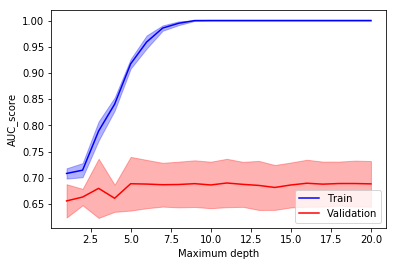

In [5]:
plt.plot(df.index,df.train_score_mean,color="b",label="Train")
plt.fill_between(df.index, df.train_score_mean - df.train_score_err,
                 df.train_score_mean + df.train_score_err, alpha=0.3,color="b")

plt.plot(df.index,df.val_score_mean,color="r",label="Validation")
plt.fill_between(df.index, df.val_score_mean - df.val_score_err,
                 df.val_score_mean + df.val_score_err, alpha=0.3,color="r")

plt.xlabel("Maximum depth")
plt.ylabel("AUC_score")
plt.legend()
plt.show()

In [13]:
model.tree_.max_depth

9

### ¿Cómo se afectan el sesgo y la varianza al aumentar la profundidad del árbol?

A mayores valores de profundidad de árbol de decisión, el sesgo es menor, puesto que el error de clasificación sobre los datos de entrenamiento disminuye. Por otro lado, si bien en literatura se indica que a profundidades altas, mayor varianza y peor desempeño sobre los datos de validación; en este caso el desempeño en validación parece estancarse. 
(Se evaluó con valores de profundidades aún mayores al gráfico (50,100,1000) sin diferencias notables).


(Pablo): Creo que el hecho de que se estanque tiene que ver con que probablemente el arbol ya haya alcanzado su altura maxima en el valor max_depth cercano a 10. O sea por mas que le pasamos max_depth = 1000, el abrol no puede llegar a esa altura, porque en altura 10 ya tiene hojas que no se pueden partir. En este sentido nuestro experimento no contradice la literatura. El hiperparametro max_depth es un hiperparametro de limite maximo, pero no pude fijar la altura que va a tener el arbol.
En conclusion yo pondria que a mayor profundidad mayor varianza y menor sesgo. el hecho de que se estanque lo podemos explicar con esto mismo que estoy escribiendo.

### SVC

In [6]:
# Tomo el mejor gamma y el mejor kernel encontrado mediante RandomSearch y GridSearch

#params=[0.01,0.1,1,10,100,1000] # Cs
#params=list(np.arange(0.10,0.25,0.01))+[0.5,0.75,1,1.5,2,3]
params=[0.00001,0.0001, 0.001, 0.1, 1, 10, 100,1000]
#params=[50,60,70,80,90,100,110,120,130,140,150]

dic={}
for c in params:
    ROC_AUC_train=[]
    ROC_AUC_val=[]
    
    for rep in range(10):
        nkfold = StratifiedKFold(n_splits=5)
        nkfold.get_n_splits(X_desarrollo,y_desarrollo)
        for train, test  in nkfold.split(X_desarrollo,y_desarrollo):
            X_train, X_val = X_desarrollo.iloc[train], X_desarrollo.iloc[test]
            y_train, y_val = y_desarrollo.iloc[train], y_desarrollo.iloc[test]

            model=SVC(C=c,kernel="rbf",gamma=0.00707269)
            model.fit(X_train,y_train)

            ROC_AUC_train.append(roc_auc_score(y_train,model.predict(X_train)))
            ROC_AUC_val.append(roc_auc_score(y_val,model.predict(X_val)))
        
    tsm=np.mean(ROC_AUC_train)
    tse=np.std(ROC_AUC_train)
    vsm=np.mean(ROC_AUC_val)
    vse=np.std(ROC_AUC_val)
    
    dic[c]={"train_score_mean":tsm,"train_score_err":tse,"val_score_mean":vsm,"val_score_err":vse}

df=pd.DataFrame(dic).T
df.reindex(params)

,train_score_err,train_score_mean,val_score_err,val_score_mean
0.00001,0.000000,0.500000,0.000000,0.500000
0.00010,0.000000,0.500000,0.000000,0.500000
0.00100,0.000000,0.500000,0.000000,0.500000
0.10000,0.000000,0.500000,0.000000,0.500000
1.00000,0.001534,0.994976,0.033213,0.751478
10.00000,0.000000,1.000000,0.038927,0.767768
100.00000,0.000000,1.000000,0.038927,0.767768
1000.00000,0.000000,1.000000,0.038927,0.767768


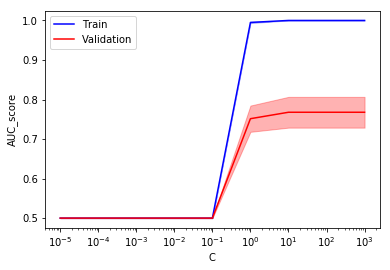

In [7]:
plt.plot(df.index,df.train_score_mean,color="b",label="Train")
plt.fill_between(df.index, df.train_score_mean - df.train_score_err,
                 df.train_score_mean + df.train_score_err, alpha=0.3,color="b")

plt.plot(df.index,df.val_score_mean,color="r",label="Validation")
plt.fill_between(df.index, df.val_score_mean - df.val_score_err,
                 df.val_score_mean + df.val_score_err, alpha=0.3,color="r")

plt.xscale("log")
plt.xlabel("C")
plt.ylabel("AUC_score")
plt.legend()
plt.show()

### ¿Cómo se afectan el sesgo y la varianza al aumentar la profundidad del árbol?
El hiperparámetro C controla un tradeoff entre maximizar el margen de separación entre los casos de entrenamiento de diferente categoría, y clasificar correctamente la mayor cantidad de casos (disminuir el error de entrenamiento). A mayores valores de C menor el error de entrenamiento, (osea menor sesgo), pero tiende a aumentar la varianza, por lo que tiende a aumentar el error de validación. 

Sin embargo, en este caso no se observa que el error de validación disminuya sino que se estanca en un minimo a valores de C mayores a 3 (evaluado a C=10,100,1000,10.000)

(Pablo): Para no repetirnos no vovleria a explicar lo que hace el hiperparametro C, ya lo explicamos en el punto anterior, por otro lado que me parece que suena un poco confuso todava, es la traduccion de la pagina de sklearn. Yo diria simplemente que a mayor C disminuye el sesgo, lo vemos en el hecho de que el trainign mejora, pero que aumenta la varianza, lo vemos en el hecho de que la distancia entre validacion y trainign aumenta. Haria una aclaración sobre que se estanca el AUC_score con C mayores que 1. Y cambiaria params a [0.00001,0.0001, 0.001, 0.1, 1, 10, 100,1000] Eso porque asi lo vi en los ejemplos, C lo van subiendo exponencialmente. (ya lo cambie, se ve en el grafico)


## :-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-

# 4.2

## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

In [87]:
from sklearn.model_selection import learning_curve

### Árboles

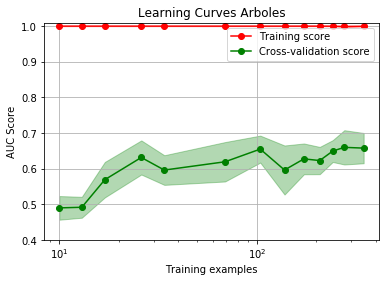

In [86]:
estimator = DecisionTreeClassifier(max_depth=10)

train_sizes=[0.03,0.04,0.05,0.075,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1]
train_sizes, train_scores, test_scores = learning_curve(estimator, X_desarrollo, y_desarrollo, cv=kfold, n_jobs=-1,train_sizes=train_sizes, scoring="roc_auc")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


title = "Learning Curves Arboles"
ylim=(0.4, 1.01)

plt.figure()
plt.title(title)
plt.ylim(*ylim)
plt.xlabel("Training examples")
plt.xscale("log")
plt.ylabel("AUC Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.3,color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.3, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
plt.legend(loc="best");
plt.show()

### SVC

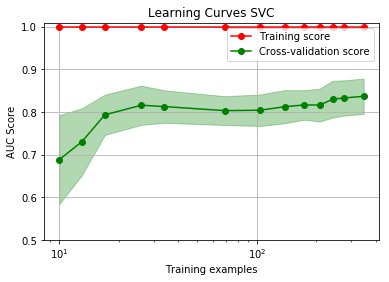

In [88]:
model = SVC(C=50,kernel="rbf",gamma=0.00707269)

train_sizes=[0.03,0.04,0.05,0.075,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1]
train_sizes, train_scores, test_scores = learning_curve(model, X_desarrollo, y_desarrollo, cv=kfold, n_jobs=-1, 
                                                        train_sizes=train_sizes, scoring="roc_auc")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


title = "Learning Curves SVC"
ylim=(0.5, 1.01)

plt.figure()
plt.title(title)
plt.ylim(*ylim)
plt.xlabel("Training examples")
plt.xscale("log")
plt.ylabel("AUC Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.3,color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.3, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
plt.legend(loc="best");
plt.show()

### ¿Más datos permitirían obtener mejores modelos?
Ambos algoritmos alcanzan rápidamente (con pocas instancias) un desempeño máximo de los modelos que generan. Esto indica que aumentar la cantidad de datos no mejoraría los modelos obtenidos mediante estos algoritmos (al menos con los hiperparámetros utilizados).

(Pablo) Mirando los graficos me parece que el de SVC termina en una tendencia ascendente, no estoy tan seguro de que no podria mejorar. Yo diria que "quizas si", aunque la pendiente sea chica y por lo tanto posiblemente no mejore mucho. En este sentido pareciera que se estanca cuando aumentamos el C pero no se estanca tanto cuando aumentamos el N.

## :-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-

# 4.3

## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

### GridSearch

In [ ]:
param_grid = {'max_features': ['sqrt', 'log2']+range(0,201,20)[1:],
              'max_depth' : range(4,20),
              'criterion' :['gini', 'entropy']}

model=RandomForestClassifier(n_estimators=200,random_state=42,n_jobs=-1)
RFgrid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, scoring='roc_auc',n_jobs=-1)
RFgrid.fit(X_desarrollo, y_desarrollo);

RFgrid.best_estimator_

### Curva de max_features

In [161]:
params=range(0,20)[1:]

dic={}
for c in params:
    ROC_AUC_train=[]
    ROC_AUC_val=[]
    
    for train, test in kfold.split(X_desarrollo,y_desarrollo):
        X_train, X_val = X_desarrollo.iloc[train], X_desarrollo.iloc[test]
        y_train, y_val = y_desarrollo.iloc[train], y_desarrollo.iloc[test]

#        model=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy', max_depth=11,max_features=c, 
#                                     max_leaf_nodes=None,min_impurity_decrease=0.0,min_impurity_split=None,
#                                     min_samples_leaf=1, min_samples_split=2,min_weight_fraction_leaf=0.0,n_estimators=200, 
#                                     n_jobs=-1,oob_score=False,random_state=42,verbose=0, warm_start=False)
        model=RFgrid.best_estimator_
        model.max_features=c
        model.fit(X_train,y_train)

        ROC_AUC_train.append(roc_auc_score(y_train,model.predict(X_train)))
        ROC_AUC_val.append(roc_auc_score(y_val,model.predict(X_val)))
        
    tsm=np.mean(ROC_AUC_train)
    tse=np.std(ROC_AUC_train)
    vsm=np.mean(ROC_AUC_val)
    vse=np.std(ROC_AUC_val)
    
    dic[c]={"train_score_mean":tsm,"train_score_err":tse,"val_score_mean":vsm,"val_score_err":vse}

df=pd.DataFrame(dic).T
df.reindex(params);

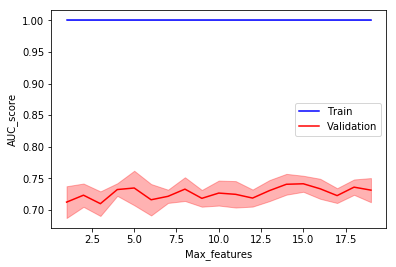

In [162]:
plt.plot(df.index,df.train_score_mean,color="b",label="Train")
plt.fill_between(df.index, df.train_score_mean - df.train_score_err,
                 df.train_score_mean + df.train_score_err, alpha=0.3,color="b")

plt.plot(df.index,df.val_score_mean,color="r",label="Validation")
plt.fill_between(df.index, df.val_score_mean - df.val_score_err,
                 df.val_score_mean + df.val_score_err, alpha=0.3,color="r")

plt.xlabel("Max_features")
plt.ylabel("AUC_score")
plt.legend()
plt.show()

### ¿Por qué creen que se dieron los resultados obtenidos?
Help!

(Pablo) Sacando features no necesariamente mejora ni empeora.
Quizas tiene que ver con el hecho de que saca al azar y que en algunas ocaciones esta sacando features importantes que no tienen ruido y aveces saca features que hacen ruido.

Dos cosas: no puedo correr esto en mi entorno por lo del +: 'max_features': ['sqrt', 'log2']+range(0,201,20)[1:]
Hay que asegurarse que lo puedan correr ellos ademas. 

Por otro lado estan bien los numeros en el eje x? no entiendo de donde salen (van de 2.5 a 17.5)


### Curva de aprendizaje

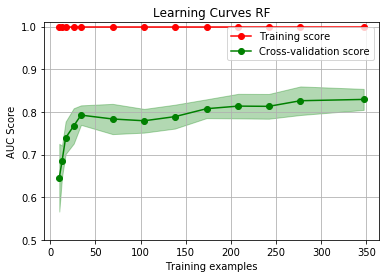

In [95]:
#model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy', max_depth=11,max_features=15, 
#                               max_leaf_nodes=None,min_impurity_decrease=0.0,min_impurity_split=None,min_samples_leaf=1, 
#                               min_samples_split=2,min_weight_fraction_leaf=0.0,n_estimators=200, n_jobs=-1,
#                               oob_score=False,random_state=42,verbose=0, warm_start=False)

model = RFgrid.best_estimator_

train_sizes=[0.03,0.04,0.05,0.075,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1]
train_sizes, train_scores, test_scores = learning_curve(model, X_desarrollo, y_desarrollo, cv=kfold, n_jobs=-1, 
                                                        train_sizes=train_sizes, scoring="roc_auc")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


title = "Learning Curves RF"
ylim=(0.5, 1.01)

plt.figure()
plt.title(title)
plt.ylim(*ylim)
plt.xlabel("Training examples")
#plt.xscale("log")
plt.ylabel("AUC Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.3,color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.3, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
plt.legend(loc="best");
plt.show()

### ¿Sería útil o no conseguir más datos?
El algoritmo alcanza rápidamente (con pocas instancias) un desempeño máximo de los modelos que genera. Esto indica que aumentar la cantidad de datos no mejoraría los modelos obtenidos mediante este algoritmo (al menos con los hiperparámetros utilizados).

(Pablo), digo lo mismo que en el grafico de SVC. me parece que termina con una pequeña tendencia ascendente.

## :-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-

# Ejercicio Extra

## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

In [97]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [98]:
param_grid = {'max_features': ['sqrt', 'log2']+range(0,201,20)[1:],
              'max_depth' : sp.stats.randint(2,20), 
              'learning_rate': np.logspace(-3,0,num=50),
              'n_estimators':sp.stats.randint(10,200)}

model=GradientBoostingClassifier(random_state = 0)

GBCgrid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=kfold, scoring='roc_auc',n_jobs=-1)
GBCgrid.fit(X_desarrollo, y_desarrollo);

GBCgrid.best_estimator_

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.0082864277285468416, loss='deviance',
              max_depth=12, max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=194,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

### Curva de aprendizaje

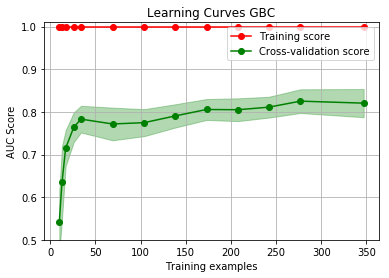

In [99]:
model=GBCgrid.best_estimator_

train_sizes=[0.03,0.04,0.05,0.075,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1]
train_sizes, train_scores, test_scores = learning_curve(model, X_desarrollo, y_desarrollo, cv=kfold, n_jobs=-1, 
                                                        train_sizes=train_sizes, scoring="roc_auc")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

title = "Learning Curves GBC"
ylim=(0.5, 1.01)

plt.figure()
plt.title(title)
plt.ylim(*ylim)
plt.xlabel("Training examples")
#plt.xscale("log")
plt.ylabel("AUC Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.3,color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.3, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
plt.legend(loc="best");
#plt.show()

La curva de aprendizaje indica que el desempeño de los modelos generados por el algoritmo llegó a un límite; por tanto, utilizando este algoritmo con los hiperparámetros seleccionados, más datos no generarían un mejor modelo.  

La curva de aprendizaje de GBC resulta muy similar a la curva de aprendizaje de Random Forest, tanto en forma como en desempeño máximo de los modelos.